In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
import pandas as pd

In [2]:
# Readig Train Data
df = pd.read_csv('data/train.csv')
del df['Ticket']
del df['Cabin']
del df["Name"]

# split to X, and y
X = df.iloc[:,2:]
y = df['Survived']

In [3]:
X.isna().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

## Transformers Pipelines

In [4]:
# create a sequential pipeline 
# output of one step will be input to the next 
Embarked_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
    )

In [5]:
Age_transformer = make_pipeline(
    SimpleImputer(strategy="mean"), StandardScaler()
    )

In [6]:
Fare_transformer = make_pipeline(
    SimpleImputer(strategy="mean"), StandardScaler()
    )

In [7]:
Pclass_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
    )

In [8]:
# Custom mapping Feature
import numpy as np
def mapping_feature(df):
    mapped=df[df.columns[0]] = df[df.columns[0]].map({'female': 1, 'male': 0}).astype(int)
    return mapped.values.reshape(-1, 1)

In [9]:
Sex_transformer = make_pipeline(
    FunctionTransformer(mapping_feature)
    )

In [10]:
#Column Transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("Age", Age_transformer, ["Age"]),
        ("Embarked", Embarked_transformer, ["Embarked"]),
        ("Fare", Fare_transformer, ["Fare"]),
        ("Pclass", Pclass_transformer, ["Pclass"]),
        ('Sex', Sex_transformer, ['Sex'])
        
    ],
    remainder='passthrough')

## Splitting and Running model on Train and Test splits

In [11]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [12]:
# split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)

X_train_transform=preprocessor.fit_transform(X_train)
X_test_transform=preprocessor.transform(X_test)
# create the model
model= LogisticRegression(max_iter=300)

####
# fit the model to training data
model.fit(X_train_transform, y_train)
###
# calculate the accuracy score from train data
print("model score on the train: %.3f" % model.score(X_train_transform, y_train))

# calculate the accuracy score from test data
print("model score on the test: %.3f" % model.score(X_test_transform, y_test))



model score on the train: 0.822
model score on the test: 0.790


In [13]:
# get predictions from the pipeline
y_pred=model.predict(X_test_transform)


## Precision vs recall

In [14]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print("Precision:     " +str(precision_score(y_test,y_pred))+ "   Recall:    "+str(recall_score(y_test,y_pred)))

Precision:     0.775   Recall:    0.6595744680851063


## Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test,y_pred)
conf

array([[189,  27],
       [ 48,  93]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

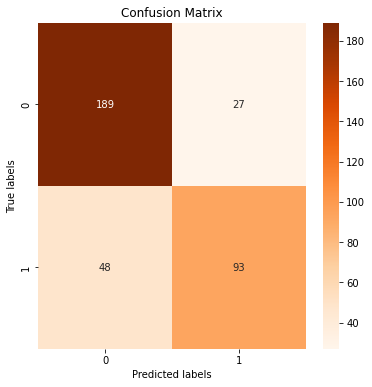

In [16]:
#plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
sns.heatmap(conf, annot=True, ax = ax,fmt='g', cmap = 'Oranges')
plt.gcf().set_facecolor('white')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

## Receiver Operator Curve and Area Under the Curve.

In [17]:
from sklearn.metrics import plot_roc_curve, auc, roc_curve
probs = model.predict_proba(X_test_transform) 
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])

Area under the curve =  0.8437417914368269


C:\Users\Master\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


(0.0, 1.0)

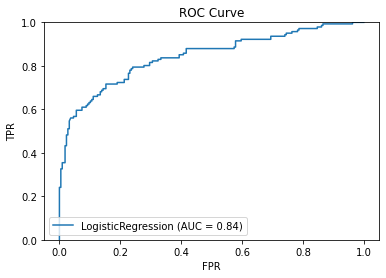

In [18]:
# Calculating area under the curve
auc_score = auc(fpr, tpr)
print("Area under the curve = ",auc_score)

plot_roc_curve(model, X_test_transform, y_test)  
plt.title("ROC Curve")
plt.gcf().set_facecolor('white')
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc="lower left")
plt.ylim([0,1.00])

## Precision Recall Curve

C:\Users\Master\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


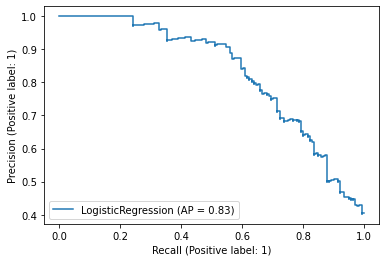

In [19]:
from sklearn.metrics import plot_precision_recall_curve
# plot precision and recall curve 
plot_precision_recall_curve(model, X_test_transform, y_test)
plt.gcf().set_facecolor('white')

In [20]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, probs[:,1])

In [21]:
# compute area under precision recall curve 
pr_area = auc(recalls, precisions)
pr_area

0.8289916811321225

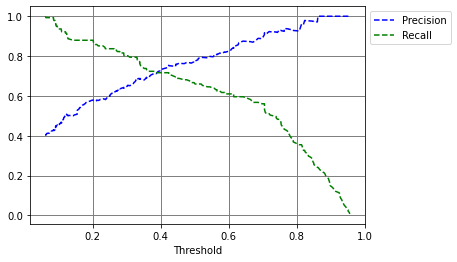

In [22]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)
plt.gcf().set_facecolor('white')
plt.show()

### Reading and Testing DATA on KAGGLE (test.csv)

In [23]:
df_test = pd.read_csv('data/test.csv')
df_testC=df_test.copy()
del df_test['Ticket']
del df_test['Cabin']
del df_test["Name"]
X_Finaltest = df_test.iloc[:,1:]
X_Finaltest

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


In [24]:
X_Finaltest.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

### Transformation of the Kaggle Test Data

In [25]:
X_Finaltest_transform=preprocessor.transform(X_Finaltest)

### Predicting of the Kaggle Test Data

In [26]:
# get predictions from the pipeline
y_Finaltestpredict=model.predict(X_Finaltest_transform)

In [27]:
gender_submission=pd.DataFrame()

In [28]:
gender_submission["PassengerId"]=df_testC["PassengerId"]
gender_submission["Survived"]=y_Finaltestpredict.reshape(-1,1)
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [29]:
gender_submission.to_csv('data/KaggleTest_LogisticRegression.csv',index=False)

## Modelling on Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
model2= RandomForestClassifier(n_estimators=100,max_depth=7)
# fit the pipeline to training data
model2.fit(X_train_transform, y_train)
###
# calculate the accuracy score from train data
print("model score on the train: %.3f" % model2.score(X_train_transform, y_train))

# calculate the accuracy score from test data
print("model score on the test: %.3f" % model2.score(X_test_transform, y_test))



model score on the train: 0.903
model score on the test: 0.798


### Predicting of the Kaggle Test Data (Random Forest)

In [31]:
# get predictions from the pipeline
y_Finaltestpredict2=model2.predict(X_Finaltest_transform)

In [32]:
gender_submission2=pd.DataFrame()
gender_submission2["PassengerId"]=df_testC["PassengerId"]
gender_submission2["Survived"]=y_Finaltestpredict2.reshape(-1,1)
gender_submission2.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [33]:
gender_submission2.to_csv('data/KaggleTest_RandomForest.csv',index=False)

## To see the Feature Names after Column Transformer

In [34]:
import warnings
import sklearn
import pandas as pd
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [35]:
X_test_transform.shape

(357, 11)

In [36]:
df_transformed=pd.DataFrame(X_test_transform, columns=get_feature_names(preprocessor))
df_transformed

C:\Users\Master\AppData\Local\Temp/ipykernel_8268/1483046653.py:33: UserWarning: Transformer simpleimputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
C:\Users\Master\AppData\Local\Temp/ipykernel_8268/1483046653.py:33: UserWarning: Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
C:\Users\Master\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Master\AppData\Local\Temp/ipykernel_8268/1483046653.py:33: UserWarning: Transformer functiontransformer (type FunctionTransformer) does not provide get_feature_names. Will return 

,Age__Age,onehotencoder__x0_C,onehotencoder__x0_Q,onehotencoder__x0_S,Fare__Fare,onehotencoder__x0_1,onehotencoder__x0_2,onehotencoder__x0_3,Sex__Sex,x3,x4
0,2.742338e-16,1.0,0.0,0.0,-0.324545,0.0,0.0,1.0,0.0,1.0,1.0
1,1.324305e-01,0.0,0.0,1.0,-0.412724,0.0,1.0,0.0,0.0,0.0,0.0
2,-7.166590e-01,0.0,0.0,1.0,-0.460569,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.797318e+00,0.0,0.0,1.0,0.005338,0.0,1.0,0.0,1.0,0.0,1.0
4,-1.179799e+00,1.0,0.0,0.0,-0.398943,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
352,2.742338e-16,0.0,0.0,1.0,-0.134635,0.0,0.0,1.0,0.0,3.0,1.0
353,-1.025419e+00,0.0,0.0,1.0,-0.412724,0.0,1.0,0.0,0.0,0.0,0.0
354,1.058710e+00,0.0,0.0,1.0,0.263608,0.0,0.0,1.0,1.0,1.0,6.0
355,-9.482288e-01,0.0,0.0,1.0,-0.446866,0.0,0.0,1.0,0.0,0.0,0.0
